<a href="https://colab.research.google.com/github/lucavauda/makemore-karpathys-lecture/blob/main/makemore2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a character-level language model

Neural architecture from Bengio et al. 2003 MLP language model paper, this is the inspiration behind this lecture.

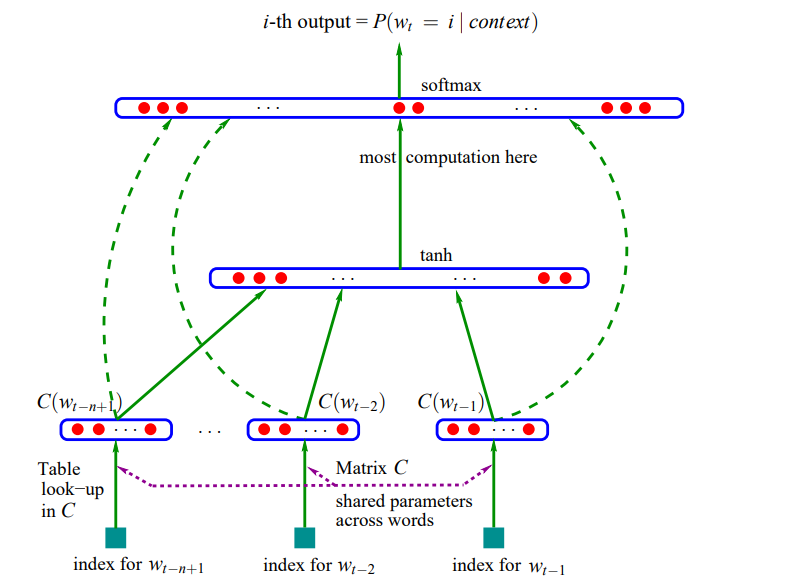

In [144]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [145]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
# print the first 8 elements
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [146]:
# print the lenght of the file
len(words)

32033

In [147]:
# build the vocabulary of charactres and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [148]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one? Hint: this is a trigram
X,Y = [], []
for w in words: # first five for efficiency ([:5]), deleting it to use all the dataset
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [149]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [206]:
# build the dataset
def build_dataset(words):
  block_size = 3
  X,Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

# splitting random words into traning, dev and test set
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [203]:
n1

25626

In [150]:
X, Y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [151]:
C = torch.rand((27, 2))

In [152]:
C[5]

tensor([0.4734, 0.5791])

In [153]:
# one hot encoding
# F.one_hot(5, num_classes=27) ---> this produce an error, must be a tensor
F.one_hot(torch.tensor(5), num_classes=27)
F.one_hot(torch.tensor(5), num_classes=27).shape

torch.Size([27])

If we directly multiply (with @ matmul op) for C, we get an error. The data type is long and the one_hot is a float. So here's what we do (hint: we cast)

In [154]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.4734, 0.5791])

We will scrape the last few lines of code. We are going to index because it is faster. Discard the one hot encording interpretation.

In [155]:
C[torch.tensor([5,6,7,7,7,7,7])] # note the same value for the 7

tensor([[0.4734, 0.5791],
        [0.5994, 0.4610],
        [0.1004, 0.5733],
        [0.1004, 0.5733],
        [0.1004, 0.5733],
        [0.1004, 0.5733],
        [0.1004, 0.5733]])

In [156]:
C[X].shape

torch.Size([228146, 3, 2])

In [157]:
X[13,2]

tensor(1)

In [158]:
C[X] [13,2] # we get the embedding

tensor([0.0443, 0.2558])

In [159]:
# to verify (unembedding) that are the same
C[1]

tensor([0.0443, 0.2558])

In [160]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [161]:
W1 = torch.rand([6,100])
b1 = torch.rand(100)

In [162]:
# emb @ W1 + b1
# this doesn't not work due to the fact that the shapes are different
# emb is 32x3x2 matrix, W1 is 32x6, we want 32x6

In [163]:
# there are multiple way to do this
# hint: always check the documentation
# torch.cat
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape
# this code is ugly, doesn't not generalize for multiple block

torch.Size([228146, 6])

In [164]:
# torch.unbind : removes a tensor direction
#torch.unbind(emb, 1)
#len(torch.unbind(emb, 1)) # exactly the list aforementioned
torch.cat(torch.unbind(emb, 1), 1).shape # the shape is actually 32x6

torch.Size([228146, 6])

In [165]:
a = torch.arange(18) # let's create an array of 18 elements
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [166]:
a.shape

torch.Size([18])

In [167]:
# there are multiple ways in which you can arrange it
# a.view(2, 9)
# a.view(9, 2)
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [168]:
# for each tensor, there is a one-dimensional vector you can access through the
# storage method
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

For a better explanation, Andrej suggest reading this [blogpost](http://blog.ezyang.com/2019/05/pytorch-internals/) about PyTorch Internals (how it works).


In [169]:
emb.shape

torch.Size([228146, 3, 2])

In [170]:
# emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1) # We can verify that a tensor is the same to one another using ==, element wise comparison

In [171]:
# If we take the code we were trying to write earlier:
# h = emb.view(emb.shape[0], 6) @ W1 + b1
# h is the hidden layer of activation
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # pytorch, using -1, infers the correct shape

In [172]:
# h.shape

In [173]:
# softmax layer
W2 = torch.randn((100, 27))
b2 = torch.randn((27))


In [174]:
# logits = h @ W2 + b2

In [175]:
# logits.shape

# Implementing the negative log likelihood loss

In [176]:
# counts = logits.exp()

In [177]:
# prob = counts / counts.sum(1, keepdim=True)

In [178]:
# prob.shape

In [179]:
# loss= -prob[torch.arange(32), Y].log().mean()
# loss

# Let's rewrite it - Start from here when using the full dataset


We modified the dataset splitting, modification to it are set accordingly. Also, we want a bigger hidden layer, so we are going to increment its parameretes.

In [275]:
Xtr.shape, Ytr.shape

(torch.Size([182441, 3]), torch.Size([182441]))

In [276]:
# be careful of the dimension of each single layer
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # increase from 2 dim embeddings to 10 dimensional embeddings
W1 = torch.randn((30, 200), generator=g) # of course the first 6 becomes 30 (3*10)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [277]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [261]:
print(f"number of params = {sum(p.nelement() for p in parameters)}")

number of params = 11897


# Skip to the forward and backward pass section

In [184]:
# you can skip this to the forward pass section
# emb = C[X] # (32, 3 ,2)
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
# logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

Let's make it even more respectable - using `cross_entropy` method

In [185]:
# F.cross_entropy(logits, Y) # notice how we get the same results
# this is much more efficient than creating more tensor. Also, the backward pass is faster
# Here's 3 reason to use the cross entropy
# 1) the forward pass is more efficient
# 2) the backward pass is more efficient
# 3) using cross entropy won't let you have bad numerical misbehaviour (eg., floating point numbers exceding )

# Forward pass and backward pass (rewrote it)

In [278]:
 for p in parameters:
  p.requires_grad = True

In [279]:
lre = torch.linspace(-3, 0 , 1000)
lrs = 10**lre

In [280]:
lri = []
lossi = []
stepi = []

In [294]:
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3 ,2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update - modify with a learning rate
  #lr = lrs[i]
  lr = 0.1 if i < 10000 else 0.01
  # we can use the learn decay loss
  # modify for the last step of the training the learning rate to be 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

# print(loss.item()) # results: 0.2554874122142792
# this means we are overfitting, so many parameters and and so few data points

In [189]:
#plt.plot(lri,lossi)

In [251]:
#plt.plot(stepi, lossi)

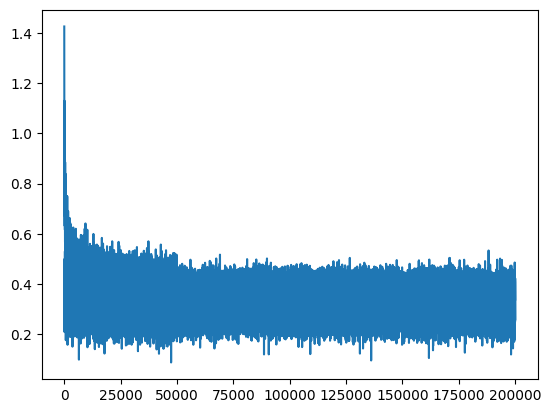

In [295]:
plt.plot(stepi,lossi)

In [190]:
# logits.max(1) # in pytorch, we can se the max along the first dimension, max reports the max value and the indicies

In [191]:
# Y print Y to check if the values are the same, for example the first are not, due to the fact that "..e" character tend to predict multiple characther

Now, we have to make sure we read all the dataset and train on the full dataset. Going to modify the start of this notebook.

The forward and the backward pass is really computationally expensive. We are now going to use minibatches.
Randomly select portion of data and only forward and update on those. Changing the main function.

In [296]:
## let's verify the loss on the test set
emb = C[Xte] # (32, 3 ,2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(loss)

tensor(2.1838, grad_fn=<NllLossBackward0>)


In [297]:
# let's verify the loss on all the dataset - then on the dev set
emb = C[Xdev] # (32, 3 ,2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss)

tensor(2.1838, grad_fn=<NllLossBackward0>)


How we determine a reasonable learning rate? First we try a really small number, eg., -0,001, but we notice that the loss doens't decrease as much as we want to. Then, let's increment it to a really big number, eg. -1. "The loss kind of explode". Infact, the loss is unstable. -10 is way to big.

So we can use `torch.linspace` and use as parameters number between -3 and 0.

We already achieved a pretty good loss, arguabily better than the last lecture.

# Splitting up th dataset
It is really important to split the dataset into train, val and test set in order to mitigate the memorization effect (overfitting). Tipically, 80%, 10% and 10%. Whichever works best, try it out. Going to modify the top part of the code.

# Larger hidden layer

During out evaluation, we notice that the loss on the dev set and on the training set is pretty much the same, this could indicate that the network is "underfitting". To avoid that, we could increment the size of the network.

Sometimes, you just have to run multiple times the script to train the network in order to get a lower loss. And play with the hyperparameters too.

Now we noticed that the 2-dimensional embedding perhaps is the bottleneck and the reason why the loss won't go under the value of 2.24 ecc.

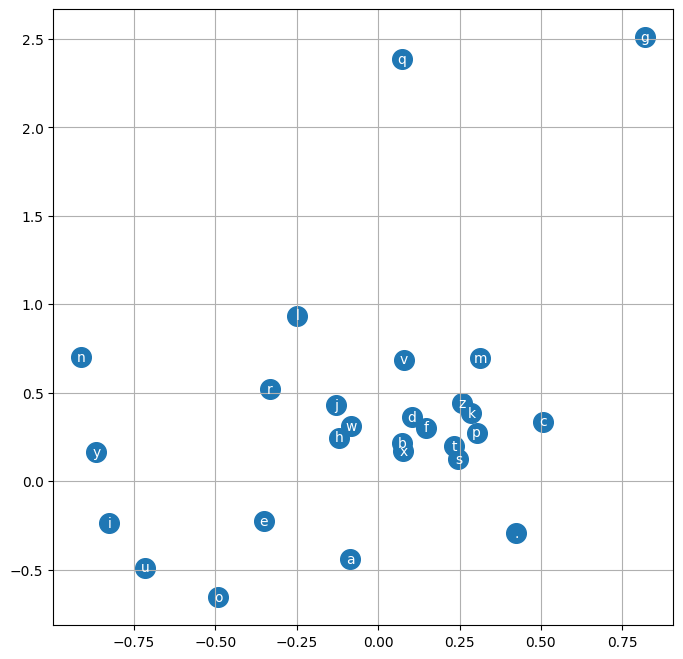

In [258]:
# little script to visualize the 2-dim embedding
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

# Sample from the model

In [299]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
ndyn.
alee.
thruthadrie.
cadered.
elin.
shi.
jenleigh.
van.
aarvelle.
malke.
cayshur.
roshiriel.
kendreelynn.
nophory.
brence.
ryyah.
faeha.
